In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from data_cleanup import *
from feature_selection import *
from model_ import *
from country_evaluation import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

In [9]:
df = load_reduced_df()

In [10]:
corr_cols = ['bci_bci', 'ti_cpi', 'vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']

### Feature selection

In [11]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}

for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, target_col=target_col)

    best_features = pre_select(X_train, y_train)
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    selected_features_dict[target_col] = set(filter_highly_correleated(X_train, best_features))


In [12]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['vdem_egal', 'wbgi_gee', 'wbgi_rqe', 'wbgi_vae', 'wbgi_rle', 'vdem_egaldem']

In [13]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['vdem_egal', 'wbgi_rle', 'wbgi_rqe', 'wbgi_vae']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [9]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


First we apply the script for the individually selected features for each corruption index.

scores


,r2,rmse
bci_bci,0.642227,72.727295
ti_cpi,0.46209,252.346144
vdem_corr,0.661686,0.027638
vdem_execorr,0.611736,0.032011
vdem_jucorrdc,0.336592,0.442823
vdem_pubcorr,0.679813,0.026126
wbgi_cce,0.850626,0.123023


feature importance


,wbgi_pve,vdem_egal,wbgi_rle,wbgi_rqe,wbgi_vae,vdem_liberal,ihme_lifexp_0104t,ihme_lifexp_0104m,vdem_egaldem,wbgi_pvn,wbgi_pvs,vdem_polyarchy
bci_bci,0.0,0.0,0.776003,0.0,0.14512,0.068093,0.0,0.010784,NaN,NaN,NaN,NaN
ti_cpi,NaN,0.01088,0.18027,0.011916,0.076711,NaN,0.053827,0.065523,0.057872,0.143246,0.399756,NaN
vdem_corr,0.030241,0.134418,0.534368,0.090242,0.058741,NaN,NaN,NaN,NaN,NaN,NaN,0.15199
vdem_execorr,NaN,0.225782,0.556483,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.217735
vdem_jucorrdc,0.003561,0.0109,0.794642,0.0,0.11355,NaN,NaN,NaN,NaN,NaN,NaN,0.077346
vdem_pubcorr,0.030043,0.162949,0.454922,0.0,0.110441,NaN,NaN,NaN,NaN,NaN,NaN,0.241646
wbgi_cce,0.019533,0.001955,0.941808,0.0,0.036704,NaN,NaN,NaN,NaN,NaN,NaN,0.0



feature importance rank


,wbgi_pve,vdem_egal,wbgi_rle,wbgi_rqe,wbgi_vae,vdem_liberal,ihme_lifexp_0104t,ihme_lifexp_0104m,vdem_egaldem,wbgi_pvn,wbgi_pvs,vdem_polyarchy
bci_bci,<NA>,<NA>,1,<NA>,2,3,<NA>,4,<NA>,<NA>,<NA>,<NA>
ti_cpi,<NA>,9,2,8,4,<NA>,7,5,6,3,1,<NA>
vdem_corr,6,3,1,4,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
vdem_execorr,<NA>,2,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3
vdem_jucorrdc,5,4,1,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3
vdem_pubcorr,5,3,1,<NA>,4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
wbgi_cce,3,4,1,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


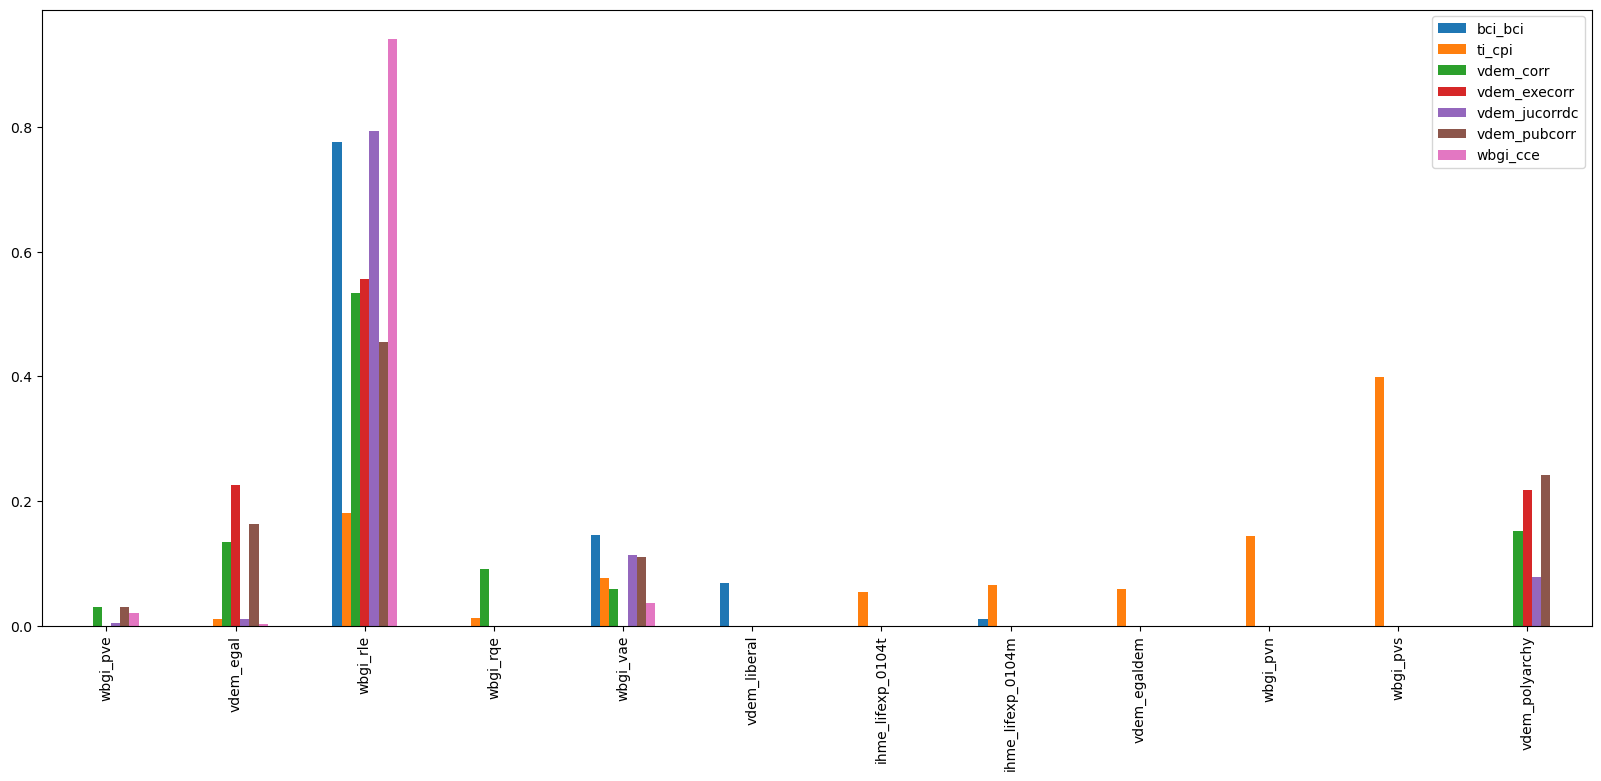

In [10]:
lasso_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
bci_bci,0.70473,60.021811
ti_cpi,0.47721,245.252948
vdem_corr,0.686548,0.025607
vdem_execorr,0.617342,0.031549
vdem_jucorrdc,0.453027,0.365103
vdem_pubcorr,0.690342,0.025267
wbgi_cce,0.871968,0.105445


feature importance


,ihme_hle_0104t,wbgi_pve,ihme_lifexp_0104f,vdem_partipdem,wbgi_gee,ihme_hle_0104m,ihme_lifexp_0104m,vdem_libdem,ihme_hle_0104f,vdem_egaldem,...,vdem_delibdem,wbgi_rqe,vdem_liberal,vdem_polyarchy,fh_pr,vdem_egal,ihme_lifexp_0104t,vdem_edcomp_thick,wbgi_pvn,wbgi_pvs
bci_bci,0.0,0.0,0.0,0.0,0.239705,0.0,0.051284,0.0,0.055812,0.0,...,0.0,0.0,0.0,0.051593,0.0,0.0,0.0,0.0,0.079676,0.050162
ti_cpi,0.0,0.0212,0.0,0.007254,0.0,0.0,0.034044,0.0,0.028716,0.0,...,0.037346,0.0,0.0,0.0,0.0,0.0,0.0,0.023403,0.126748,0.390278
vdem_corr,0.0,0.019381,0.004403,0.087476,0.142153,0.0,0.0,0.32664,0.0,0.0,...,0.002914,0.045269,0.0,0.077899,0.00396,0.046758,0.011559,0.0,0.044602,0.041127
vdem_execorr,0.0,0.013573,0.0,0.0,0.189072,0.0,0.0,0.186306,0.0,0.0,...,0.0,0.009634,0.175097,0.0,0.0,0.112093,0.0,0.006192,0.0,0.007006
vdem_jucorrdc,0.019525,0.002512,0.013983,0.029388,0.069475,0.000334,0.0,0.252056,0.0,0.0,...,0.052086,0.031578,0.005705,0.186093,0.017254,0.013201,0.0,0.077935,0.023154,0.022201
vdem_pubcorr,0.0,0.036012,0.015552,0.0,0.23768,0.0,0.024107,0.210879,0.0,0.0,...,0.0,0.020247,0.063259,0.0,0.0,0.098095,0.0,0.001663,0.053004,0.033547
wbgi_cce,0.0,0.01037,0.0,0.0,0.289892,0.0,0.039971,0.016006,0.061082,0.012809,...,0.0,0.021795,0.0,0.0,0.0,0.0,0.0,0.0,0.080489,0.044497



feature importance rank


,ihme_hle_0104t,wbgi_pve,ihme_lifexp_0104f,vdem_partipdem,wbgi_gee,ihme_hle_0104m,ihme_lifexp_0104m,vdem_libdem,ihme_hle_0104f,vdem_egaldem,...,vdem_delibdem,wbgi_rqe,vdem_liberal,vdem_polyarchy,fh_pr,vdem_egal,ihme_lifexp_0104t,vdem_edcomp_thick,wbgi_pvn,wbgi_pvs
bci_bci,<NA>,<NA>,<NA>,<NA>,2,<NA>,7,<NA>,4,<NA>,...,<NA>,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,3,8
ti_cpi,<NA>,10,<NA>,11,<NA>,<NA>,7,<NA>,8,<NA>,...,6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9,3,1
vdem_corr,<NA>,11,13,4,2,<NA>,<NA>,1,<NA>,<NA>,...,15,7,<NA>,5,14,6,12,<NA>,8,9
vdem_execorr,<NA>,7,<NA>,<NA>,2,<NA>,<NA>,3,<NA>,<NA>,...,<NA>,8,4,<NA>,<NA>,5,<NA>,10,<NA>,9
vdem_jucorrdc,13,19,15,10,4,20,<NA>,1,<NA>,<NA>,...,7,9,18,2,14,16,<NA>,3,11,12
vdem_pubcorr,<NA>,8,13,<NA>,1,<NA>,11,2,<NA>,<NA>,...,<NA>,12,5,<NA>,<NA>,4,<NA>,14,6,10
wbgi_cce,<NA>,12,<NA>,<NA>,2,<NA>,6,9,4,11,...,<NA>,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,5


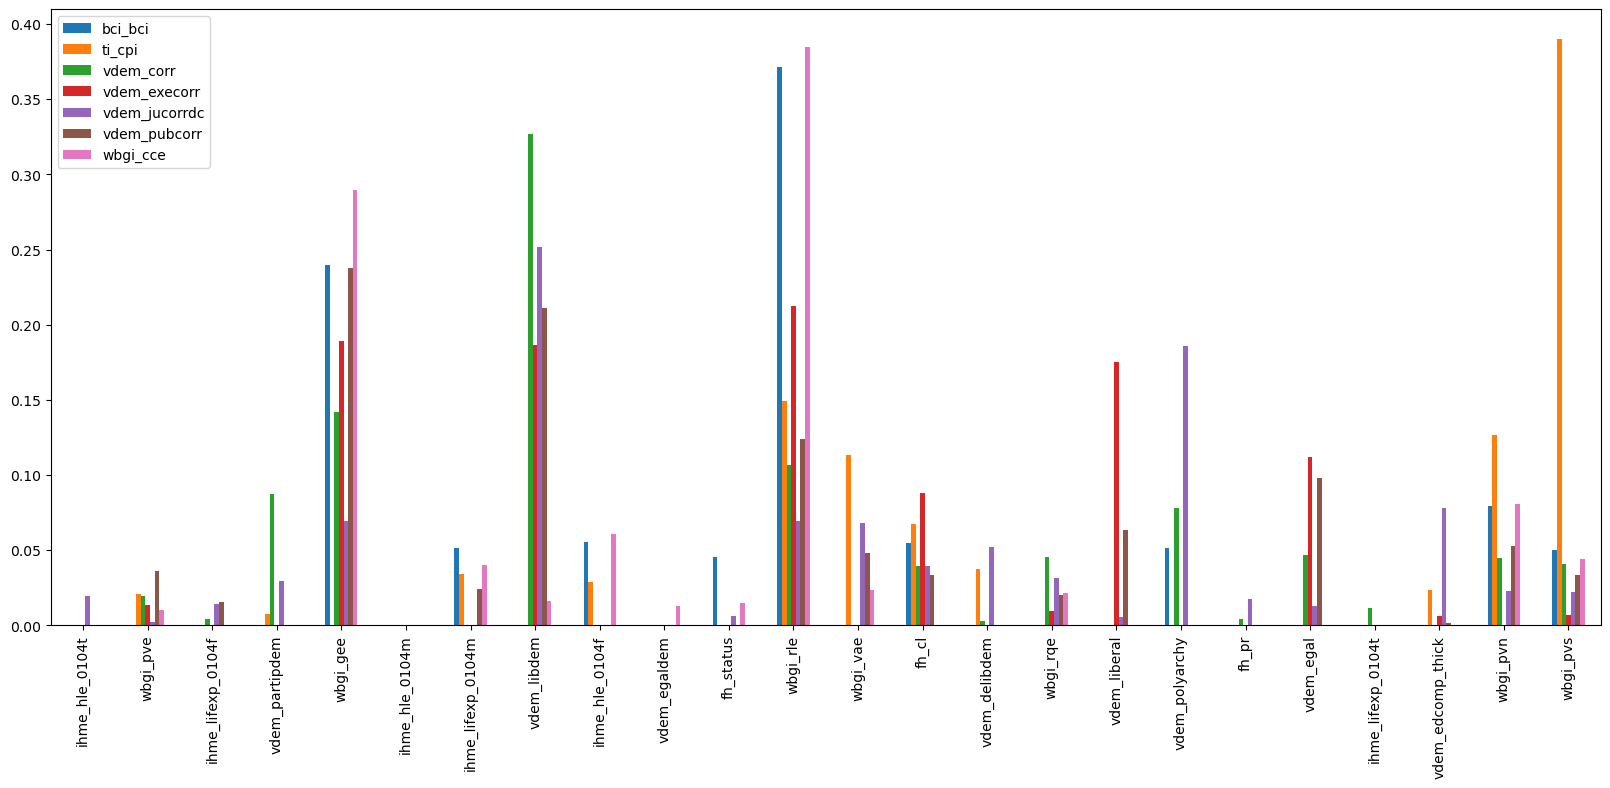

In [11]:
lasso_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
bci_bci,0.640953,72.986303
ti_cpi,0.093176,425.41252
vdem_corr,0.652719,0.028371
vdem_execorr,0.602062,0.032809
vdem_jucorrdc,0.332133,0.4458
vdem_pubcorr,0.684928,0.025709
wbgi_cce,0.848395,0.12486


feature importance


,wbgi_rle,wbgi_vae,vdem_egal,wbgi_rqe
bci_bci,0.772239,0.212816,0.014944,0.0
ti_cpi,1.0,0.0,0.0,0.0
vdem_corr,0.587571,0.125321,0.186455,0.100653
vdem_execorr,0.505538,0.227506,0.266957,0.0
vdem_jucorrdc,0.77111,0.205012,0.023877,0.0
vdem_pubcorr,0.533446,0.198988,0.267566,0.0
wbgi_cce,0.958001,0.037146,0.004854,0.0



feature importance rank


,wbgi_rle,wbgi_vae,vdem_egal,wbgi_rqe
bci_bci,1,2,3,<NA>
ti_cpi,1,<NA>,<NA>,<NA>
vdem_corr,1,3,2,4
vdem_execorr,1,3,2,<NA>
vdem_jucorrdc,1,2,3,<NA>
vdem_pubcorr,1,3,2,<NA>
wbgi_cce,1,2,3,<NA>


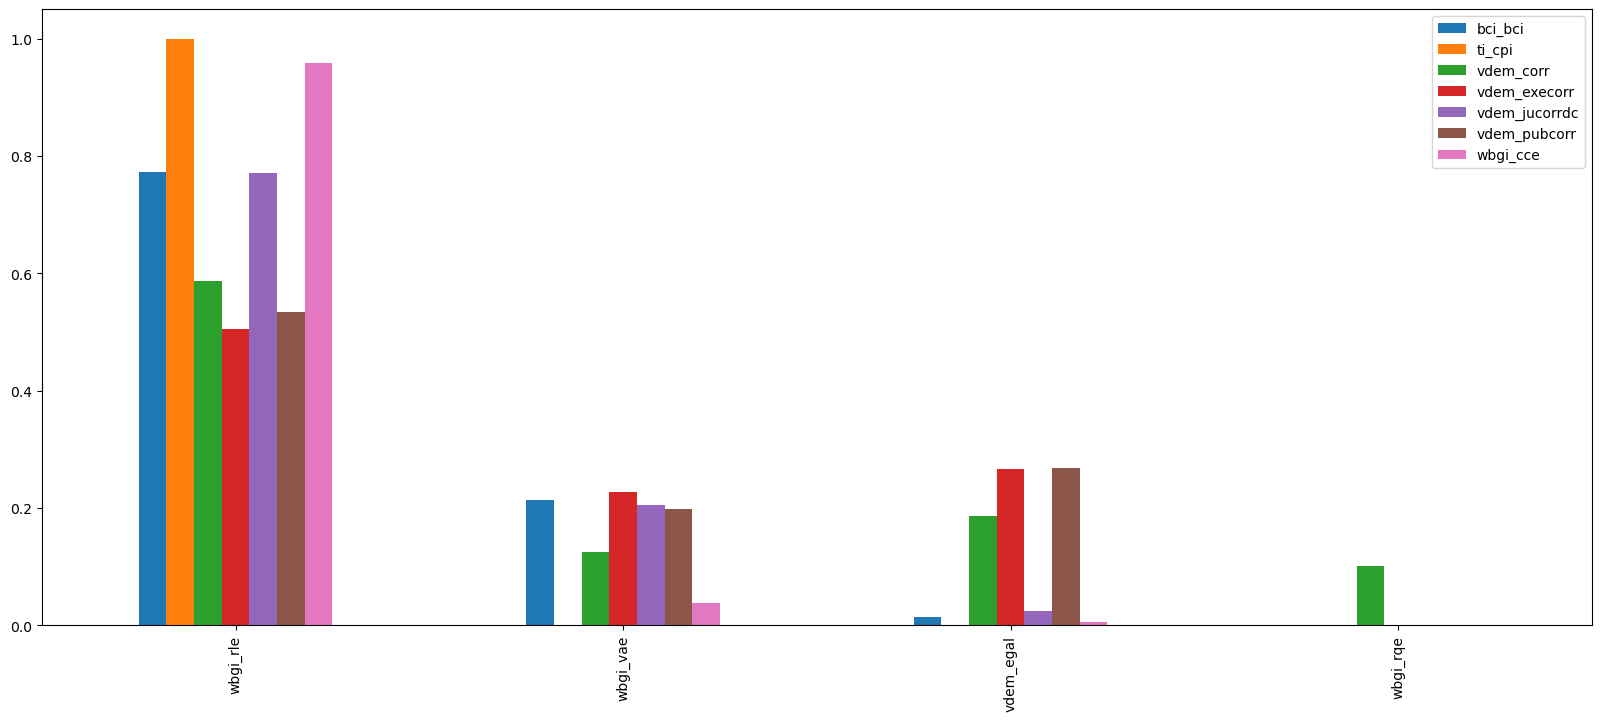

In [12]:
lasso_info_script(selected_features_intersection)

Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [14]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    # l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    # df_fi = pd.concat(l_fi)

    # l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    # df_firk = pd.concat(l_firk)

    # print('feature importance')
    # display(df_fi)

    # df_fi.T.plot(kind='bar', figsize=(20,8))
    # print()

    # print('feature importance rank')
    # display(df_firk)
    # print()
    return rf_bf



In [15]:
rf_bf = rf_info_script(selected_features_dict)

scores


,r2,rmse
bci_bci,0.642922,72.586032
ti_cpi,0.932475,31.677649
vdem_corr,0.7155,0.023242
vdem_execorr,0.592651,0.033585
vdem_jucorrdc,0.334364,0.444311
vdem_pubcorr,0.636782,0.029637
wbgi_cce,0.854346,0.119958


In [16]:
threshold = 0.3

In [28]:
relative_errs = get_rel_err_df(rf_bf, df, corr_cols, threshold)

In [18]:
relative_errs[relative_errs.rel_err > 1.0].groupby('corr_id').rel_err.agg(['count', 'min', 'max', 'mean'])

,count,min,max,mean
corr_id,,,,
ti_cpi,40,1.027047,5.991766,3.034633
vdem_corr,74,1.008513,4.491771,2.390555
vdem_execorr,66,1.014167,11.723846,3.454059
vdem_jucorrdc,6,1.024188,2.158443,1.440384
vdem_pubcorr,73,1.079709,15.488065,3.312380
wbgi_cce,114,1.020312,477.250952,7.417643


In [19]:
relative_errs[relative_errs.rel_err > 450]

,original_id,region,cname,year,corr_id,rel_err,rel_err_status
3797,11035,Africa,Rwanda,2007,wbgi_cce,477.250952,bad


In [20]:
df.loc[df.cname == 'Rwanda', ['wbgi_cce', 'year']]

,wbgi_cce,year
11033,-0.617956,2005
11034,-0.208082,2006
11035,-0.001274,2007
11036,0.096269,2008
11037,0.089928,2009
11038,0.353755,2010
11039,0.357639,2011
11040,0.557709,2012
11041,0.627993,2013
11042,0.762648,2014


In [21]:
px.histogram(relative_errs[relative_errs.rel_err <= 1.0],
# px.histogram(relative_errs,  
            x='rel_err', 
            hover_data=['region', 'cname', 'year'],
            title='Distribution of relative errors')

In [34]:
px.histogram(relative_errs[relative_errs.rel_err <= 1.0], 
# px.histogram(relative_errs,
            x='rel_err', 
            hover_data=['region', 'cname', 'year'], 
            # color='sub-region',
            color='region',
            barmode='overlay',
            histnorm='probability',
            title='Distribution of relative errors (by region)')

In [33]:
px.histogram(relative_errs[relative_errs.rel_err <= 1.0], 
# px.histogram(relative_errs[relative_errs.rel_err >= 1.0], 
# px.histogram(relative_errs,
            x='rel_err', 
            hover_data=['region', 'cname', 'year'], 
            color='corr_id',
            histnorm='probability',
            barmode='overlay',
            title='Distribution of relative errors (by region)')

In [35]:
## create table with percent of bad vs good predictions for a country

In [24]:
relative_errs_per_country_full = get_rel_err_df_stats(relative_errs) 
relative_errs_per_country_full

rel_err
cname    corr_id       rel_err_status         
Albania  bci_bci       good                 16
         ti_cpi        bad                   2
                       good                 14
         total         bad                   7
                       good                105
...                                        ...
Zimbabwe vdem_jucorrdc good                  1
         vdem_pubcorr  bad                   1
                       good                 17
         wbgi_cce      bad                   1
                       good                 17

[441 rows x 1 columns]

First we apply again the script for the individually selected features for each corruption index.

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
bci_bci,0.67806,65.443177
ti_cpi,0.940047,28.125389
vdem_corr,0.663385,0.027499
vdem_execorr,0.633052,0.030254
vdem_jucorrdc,0.336604,0.442816
vdem_pubcorr,0.646311,0.02886
wbgi_cce,0.865275,0.110958


feature importance


,ihme_hle_0104t,vdem_egaldem,vdem_egal,wbgi_pve,vdem_edcomp_thick,wbgi_pvn,ihme_lifexp_0104m,ihme_hle_0104m,fh_cl,wbgi_rle,...,vdem_polyarchy,fh_pr,wbgi_vae,ihme_lifexp_0104t,vdem_libdem,vdem_delibdem,wbgi_pvs,wbgi_gee,ihme_lifexp_0104f,fh_status
bci_bci,0.00225,0.006195,0.010515,0.007003,0.005915,0.00367,0.002734,0.003135,0.002157,0.489529,...,0.023278,0.001461,0.007898,0.001838,0.019121,0.009024,0.002338,0.364987,0.003322,0.000913
ti_cpi,0.000877,0.001633,0.004425,0.006456,0.001983,0.017602,0.001865,0.000963,0.000589,0.267588,...,0.001136,0.00021,0.003814,0.000727,0.000977,0.001905,0.664836,0.007566,0.000971,0.000171
vdem_corr,0.002583,0.007634,0.268587,0.014504,0.010905,0.001474,0.005535,0.003937,0.000894,0.43303,...,0.007253,0.001429,0.017785,0.002225,0.062053,0.005511,0.001903,0.026078,0.003863,0.000267
vdem_execorr,0.002426,0.014855,0.468322,0.013082,0.01334,0.002068,0.005973,0.004045,0.002516,0.097297,...,0.008287,0.002244,0.013402,0.00244,0.091807,0.016227,0.003641,0.043233,0.003122,0.000529
vdem_jucorrdc,0.004176,0.007146,0.022012,0.011525,0.012462,0.002079,0.005765,0.006723,0.002042,0.684075,...,0.006619,0.001261,0.042483,0.003767,0.01077,0.007199,0.002183,0.026865,0.003935,0.000267
vdem_pubcorr,0.001745,0.167766,0.16879,0.015368,0.008163,0.001392,0.002366,0.003471,0.001356,0.262983,...,0.006969,0.001444,0.004142,0.002108,0.112075,0.004612,0.002791,0.152349,0.003386,0.000302
wbgi_cce,0.000922,0.002508,0.004493,0.006513,0.0023,0.001108,0.001604,0.001259,0.000836,0.874723,...,0.002036,0.000509,0.00583,0.000918,0.002509,0.001627,0.002087,0.074322,0.001481,0.000188



feature importance rank


,ihme_hle_0104t,vdem_egaldem,vdem_egal,wbgi_pve,vdem_edcomp_thick,wbgi_pvn,ihme_lifexp_0104m,ihme_hle_0104m,fh_cl,wbgi_rle,...,vdem_polyarchy,fh_pr,wbgi_vae,ihme_lifexp_0104t,vdem_libdem,vdem_delibdem,wbgi_pvs,wbgi_gee,ihme_lifexp_0104f,fh_status
bci_bci,20,12,5,10,13,15,18,17,21,1,...,3,23,9,22,4,8,19,2,16,24
ti_cpi,20,13,7,6,9,3,11,19,22,2,...,15,23,8,21,17,10,1,5,18,24
vdem_corr,18,9,2,7,8,21,13,16,23,1,...,10,22,6,19,4,14,20,5,17,24
vdem_execorr,21,7,1,10,9,23,14,16,19,3,...,13,22,8,20,4,6,17,5,18,24
vdem_jucorrdc,17,12,5,7,6,21,15,13,22,1,...,14,23,3,19,8,11,20,4,18,24
vdem_pubcorr,20,3,2,7,8,22,18,15,23,1,...,9,21,14,19,5,13,17,4,16,24
wbgi_cce,20,9,6,3,10,19,16,18,22,1,...,14,23,4,21,8,15,13,2,17,24


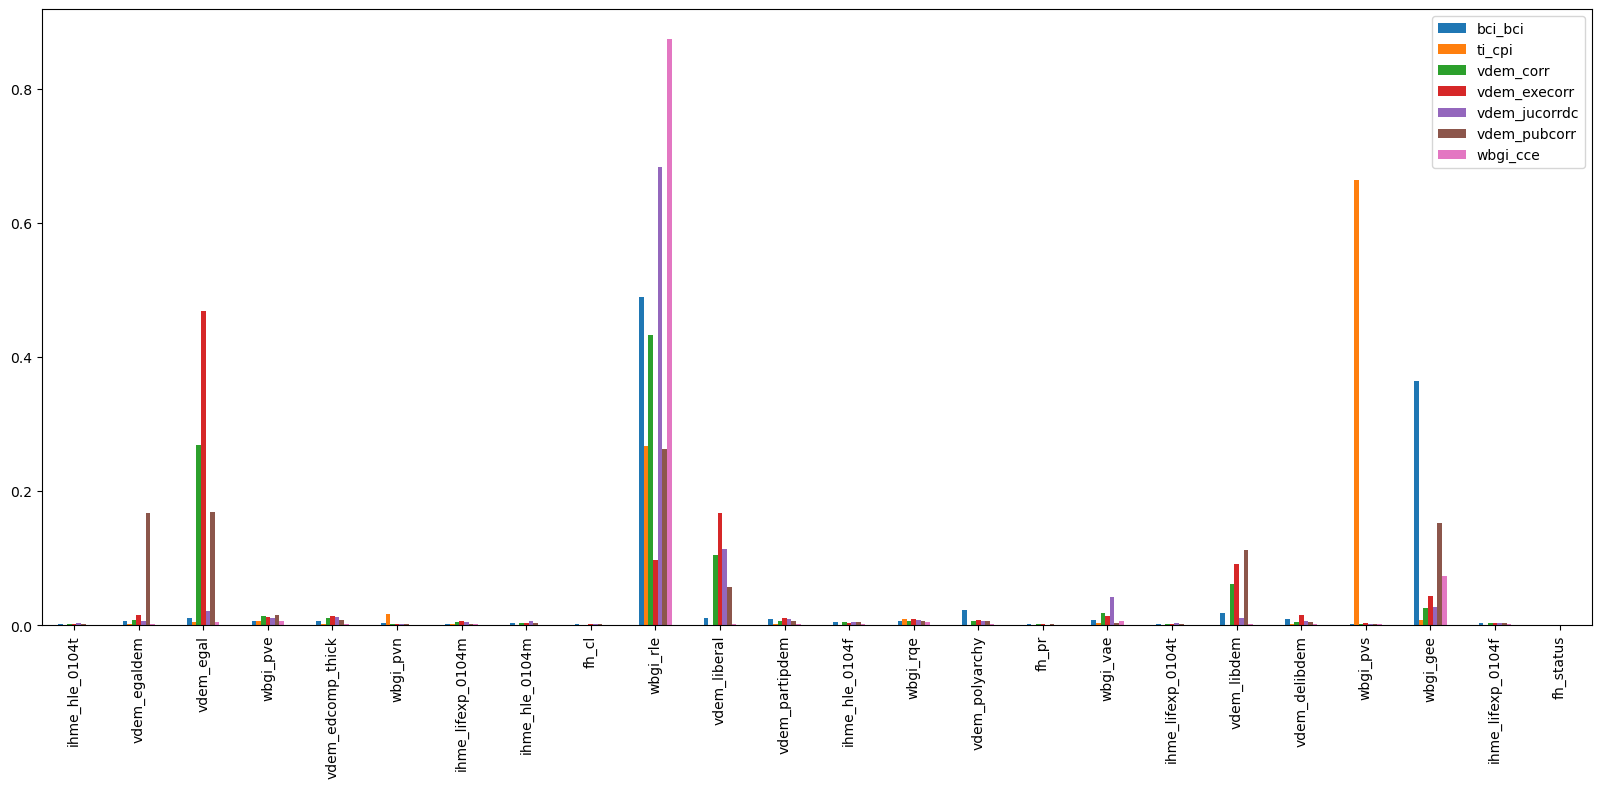

In [ ]:
rf_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
bci_bci,0.63259,74.686181
ti_cpi,-0.068481,501.249572
vdem_corr,0.654381,0.028235
vdem_execorr,0.576975,0.034877
vdem_jucorrdc,0.287023,0.475911
vdem_pubcorr,0.617838,0.031183
wbgi_cce,0.837614,0.133739


feature importance


,wbgi_vae,wbgi_rqe,vdem_egal,wbgi_rle
bci_bci,0.067195,0.026167,0.041292,0.865347
ti_cpi,0.21765,0.246044,0.21021,0.326096
vdem_corr,0.109781,0.030122,0.330337,0.529759
vdem_execorr,0.097407,0.052492,0.652683,0.197418
vdem_jucorrdc,0.113241,0.043975,0.070357,0.772428
vdem_pubcorr,0.12354,0.035558,0.324264,0.516638
wbgi_cce,0.01996,0.014665,0.016506,0.948869



feature importance rank


,wbgi_vae,wbgi_rqe,vdem_egal,wbgi_rle
bci_bci,2,4,3,1
ti_cpi,3,2,4,1
vdem_corr,3,4,2,1
vdem_execorr,3,4,1,2
vdem_jucorrdc,2,4,3,1
vdem_pubcorr,3,4,2,1
wbgi_cce,2,4,3,1


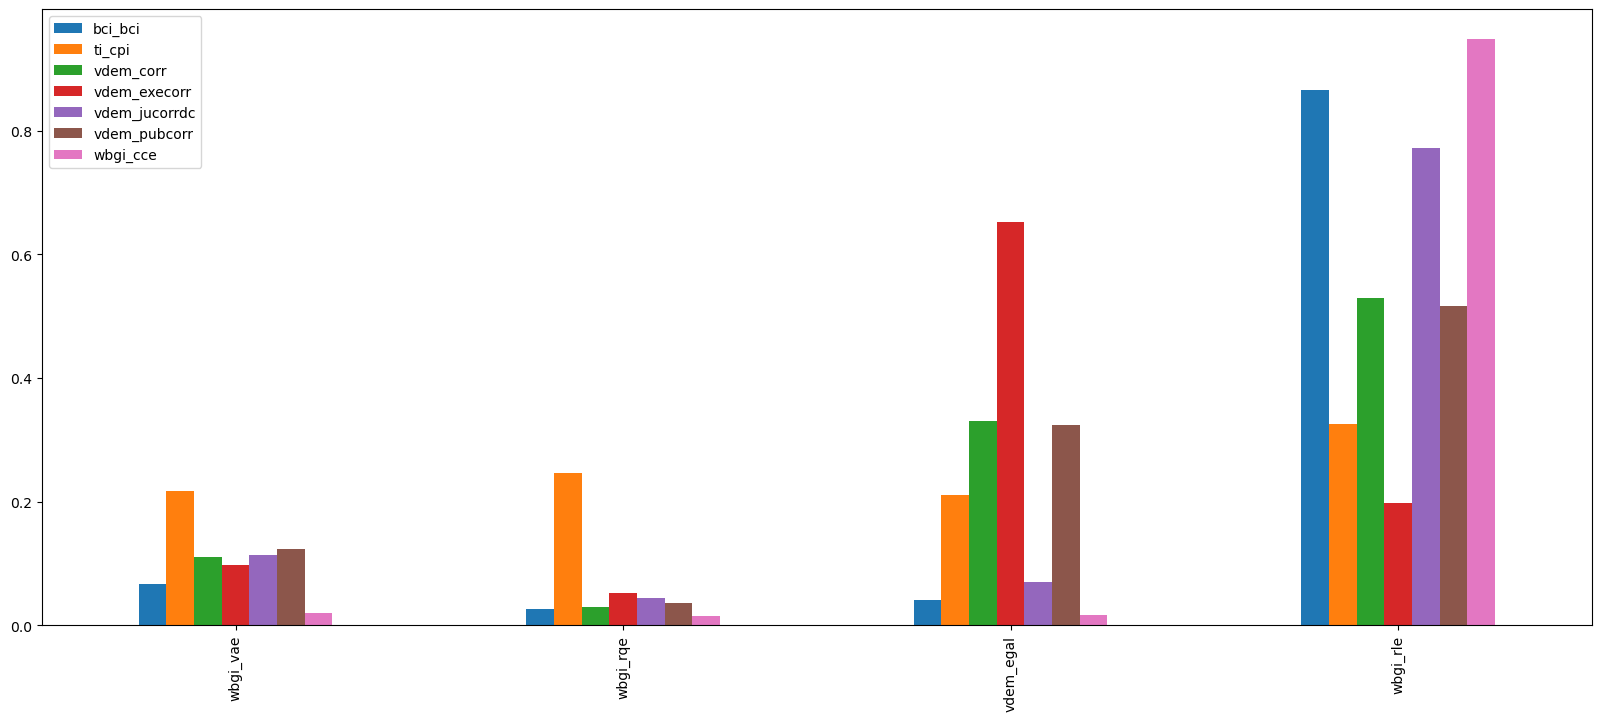

In [ ]:
rf_info_script(selected_features_intersection)

The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [ ]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()

    print('params')
    display(df_params)
    print()


Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

scores


,r2,rmse
bci_bci,0.654786,70.174219
ti_cpi,0.934032,30.94708
vdem_corr,0.710963,0.023613
vdem_execorr,0.633153,0.030246
vdem_jucorrdc,0.400292,0.400304
vdem_pubcorr,0.662066,0.027574
wbgi_cce,0.884323,0.09527


feature importance


,wbgi_rqe,vdem_egal,wbgi_rle,wbgi_pve,vdem_liberal,wbgi_vae,ihme_lifexp_0104t,ihme_lifexp_0104m,vdem_egaldem,wbgi_pvs,wbgi_pvn,vdem_polyarchy
bci_bci,0.003639,0.011342,0.918237,0.004022,0.03786,0.020091,0.002247,0.002562,NaN,NaN,NaN,NaN
ti_cpi,0.012189,0.009736,0.273914,NaN,NaN,0.005665,0.002156,0.002945,0.003607,0.669503,0.020285,NaN
vdem_corr,0.14135,0.248206,0.268361,0.022895,NaN,0.241057,NaN,NaN,NaN,NaN,NaN,0.078132
vdem_execorr,0.047048,0.290362,0.187757,NaN,NaN,0.301151,NaN,NaN,NaN,NaN,NaN,0.173682
vdem_jucorrdc,0.228524,0.079348,0.306222,0.02609,NaN,0.300931,NaN,NaN,NaN,NaN,NaN,0.058884
vdem_pubcorr,0.125795,0.246013,0.249932,0.030649,NaN,0.187161,NaN,NaN,NaN,NaN,NaN,0.160449
wbgi_cce,0.308524,0.078076,0.329789,0.078384,NaN,0.18977,NaN,NaN,NaN,NaN,NaN,0.015456



feature importance rank


,wbgi_rqe,vdem_egal,wbgi_rle,wbgi_pve,vdem_liberal,wbgi_vae,ihme_lifexp_0104t,ihme_lifexp_0104m,vdem_egaldem,wbgi_pvs,wbgi_pvn,vdem_polyarchy
bci_bci,6,4,1,5,2,3,8,7,<NA>,<NA>,<NA>,<NA>
ti_cpi,4,5,2,<NA>,<NA>,6,9,8,7,1,3,<NA>
vdem_corr,4,2,1,6,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,5
vdem_execorr,5,2,3,<NA>,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,4
vdem_jucorrdc,3,4,1,6,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,5
vdem_pubcorr,5,2,1,6,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,4
wbgi_cce,2,5,1,4,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,6



params


,randomforestregressor__max_depth,randomforestregressor__max_features,randomforestregressor__min_samples_split
bci_bci,5,None,2
ti_cpi,None,None,2
vdem_corr,5,log2,3
vdem_execorr,5,log2,5
vdem_jucorrdc,5,log2,10
vdem_pubcorr,None,log2,2
wbgi_cce,10,log2,5


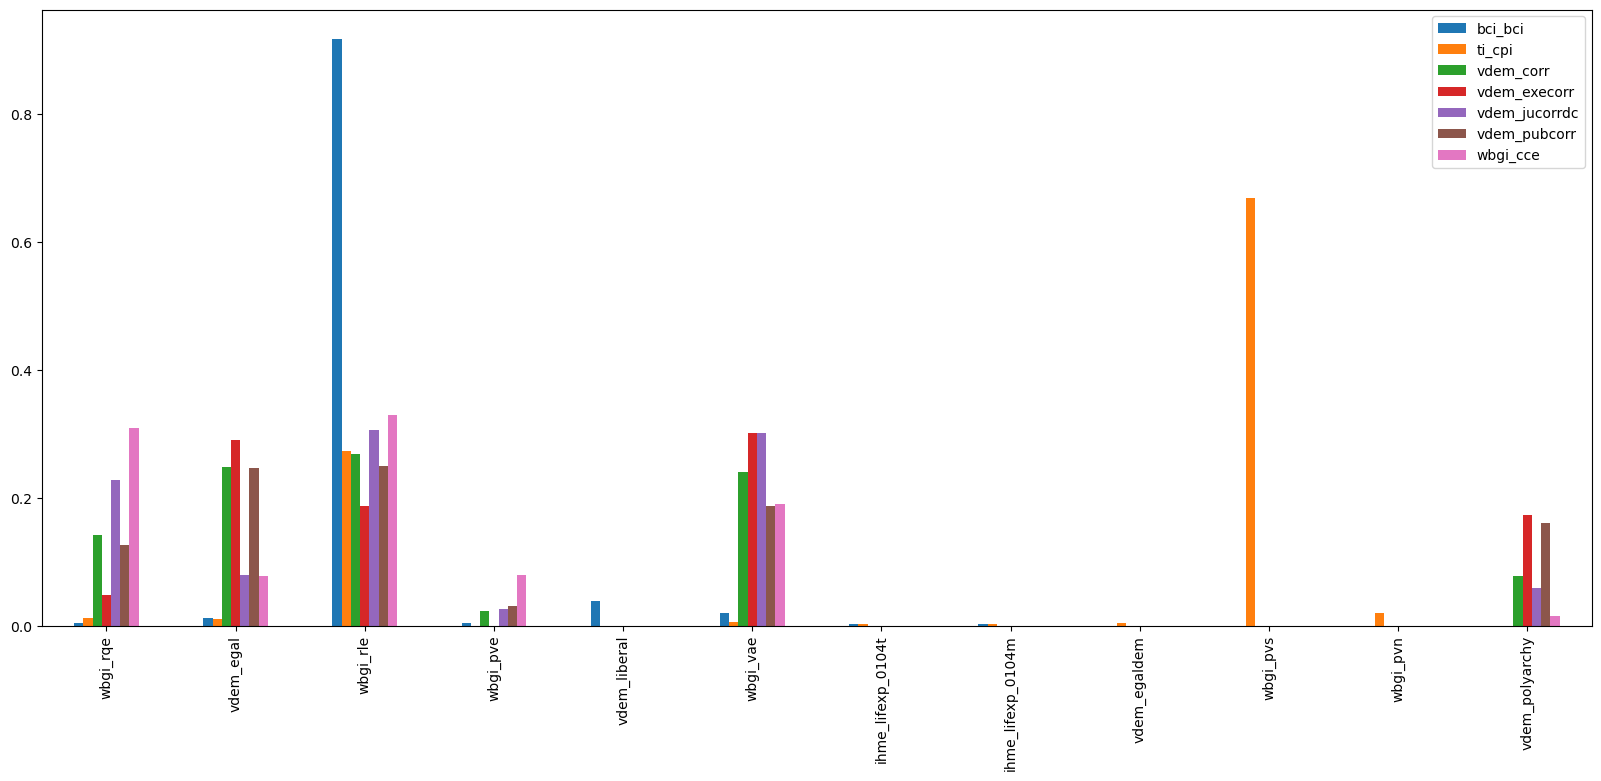

In [ ]:
rf_gridsearch_info_script(selected_features_dict)

For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.